In [124]:
## Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## To draw DT
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import sklearn
## Embeded Datasets
from sklearn import datasets

## For shuffling the Dataset
from sklearn import utils

## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict

## Algorithms
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## Metric
from sklearn.metrics import accuracy_score, r2_score

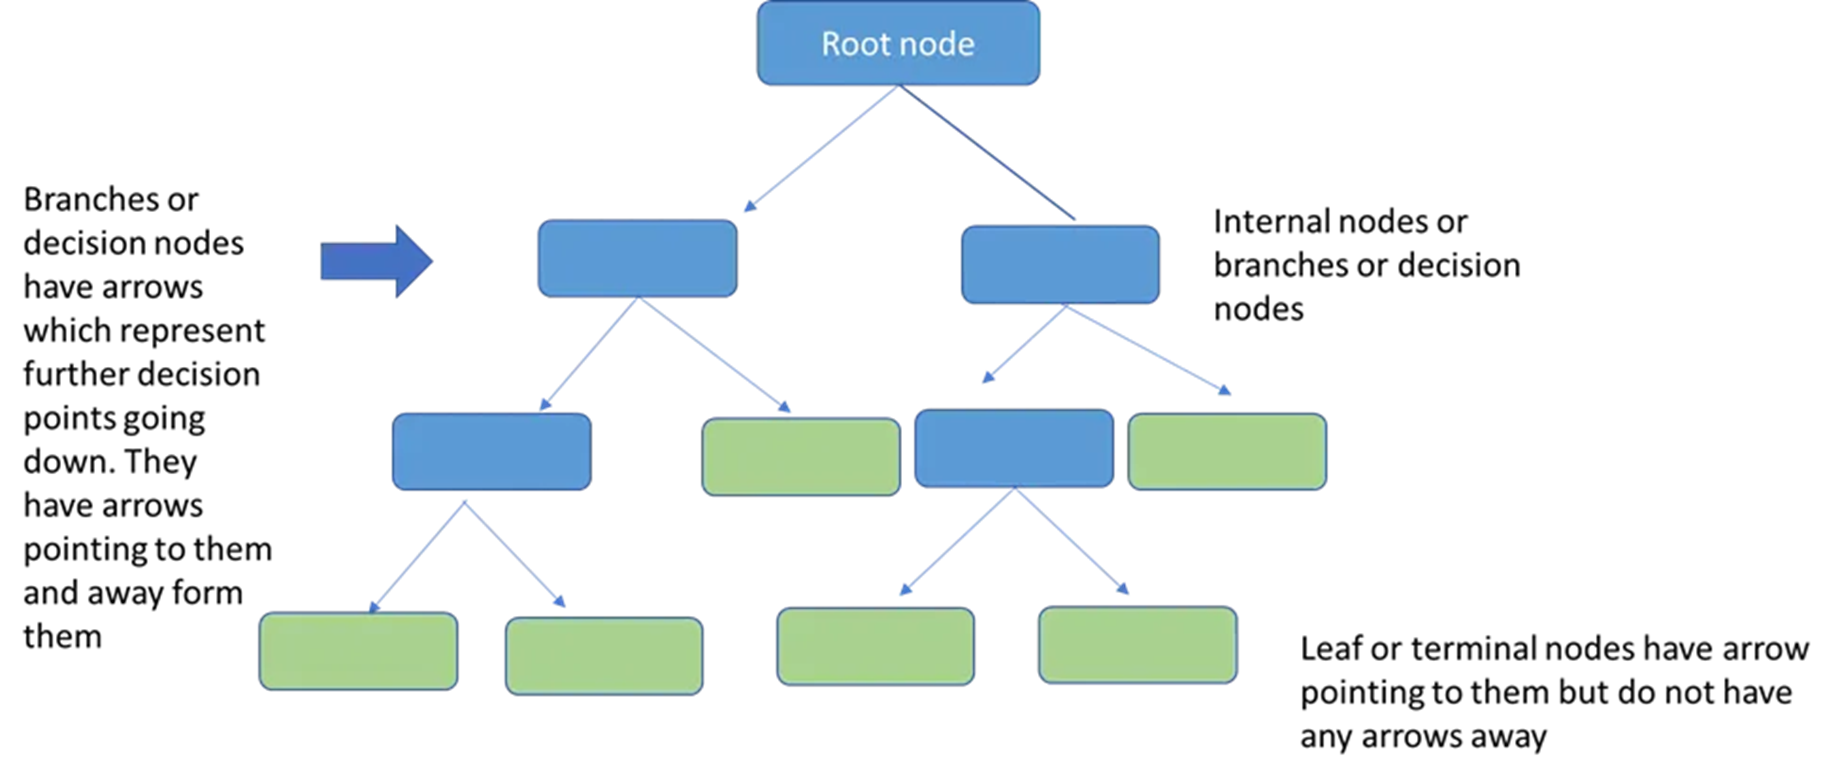

# Model Implementation

- **We'll start with all examples at the root node then:**

- **We'll calculate information gain for splitting on all possible features and pick the one with the highest value**

- **Then we'll split the data according to the selected feature**

- **We'll repeat this  process until stopping criteria is met**



### Entropy
**Entropy function which is a way to measure impurity**

**Entropy is represented by this function**
$$H = -\sum\limits_{}^{} p_{i}\text{log}_2 p_{i} 
$$

**Where $(p_1)$ is the fraction of examples that are a certain class**





In [125]:
iris_dataset = datasets.load_iris()

iris     = np.c_[iris_dataset['data'], iris_dataset['target']]
features = iris_dataset['feature_names'] + ['target']

In [126]:
## Let's impute (although there is no nulls) and standardize the Dataset ---> All in Pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
                              ]
                       )

iris[:,:-1] = num_pipeline.fit_transform(iris[:,:-1])

In [127]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        Initializes a new instance of the Node class.

        Args:
            feature: The feature used for splitting at this node. Defaults to None.
            threshold: The threshold used for splitting at this node. Defaults to None.
            left: The left child node. Defaults to None.
            right: The right child node. Defaults to None.
            gain: The gain of the split. Defaults to None.
            value: If this node is a leaf node, this attribute represents the predicted value
                for the target variable. Defaults to None.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value


### Calculate Entropy

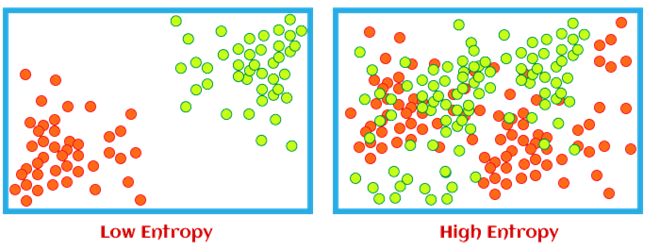

In [128]:
def entropy(y):
    """
    Computes the entropy of the given label values.
    """
    entropy = 0

    # Find the unique label values in y and loop over each value
    labels = np.unique(y)
    for label in labels:
        # Find the examples in y that have the current label
        label_examples = y[y == label]
        # Calculate the ratio of the current label in y
        pl = len(label_examples) / len(y)
        # Calculate the entropy using the current label and ratio
        entropy += -pl * np.log2(pl)
    # Return the final entropy value
    return entropy

In [129]:
def split_data(dataset, feature, threshold):
    """
    Splits the given dataset into two datasets based on the given feature and threshold.

    Parameters:
        dataset (array) : Input dataset.
        feature (int) : Index of the feature to be split on.
        threshold (int) : Threshold value to split the feature on.
    """
    # Create empty arrays to store the left and right datasets
    left_dataset = []
    right_dataset = []
    # Loop over each row in the dataset and split based on the given feature and threshold
    for row in dataset:
        if row[feature] <= threshold:

            left_dataset.append(row)
        else:
            right_dataset.append(row)

    # Convert the left and right datasets to numpy arrays and return
    left_dataset = np.array(left_dataset)
    right_dataset = np.array(right_dataset)
    return left_dataset, right_dataset

In [130]:
# splitting the dataset according to threshold 't' and feature 'f'
left_dataset, right_dataset = split_data(iris, 3, -0.526)
# lenghts of the datset after splitting
len(left_dataset), len(right_dataset), len(iris)

(50, 100, 150)

 we will split the data on a threashold in the petal width column that maximizes the information gain

### Information Gain

**Information gain is the reduction in entropy when he make a split**

**Recall that our goal is to choose the split that gives the highest information gain, information gain equation =**

**$$H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$**
**where** 
- $H(p_1^\text{node})$ is entropy at the node 
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch respectively

In [131]:
def information_gain(parent, left, right):
    """
    Computes the information gain from splitting the parent dataset into two datasets.

    Parameters:
        parent (ndarray): Input parent dataset.
        left (ndarray): Subset of the parent dataset after split on a feature.
        right (ndarray): Subset of the parent dataset after split on a feature.
    """
    # set initial information gain to 0
    information_gain = 0
    # compute entropy for parent
    parent_entropy = entropy(parent)
    # calculate weight for left and right nodes
    weight_left = len(left) / len(parent)
    weight_right= len(right) / len(parent)
    # compute entropy for left and right nodes
    entropy_left, entropy_right = entropy(left), entropy(right)
    # calculate weighted entropy
    weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
    # calculate information gain 
    information_gain =  parent_entropy - weighted_entropy

    return information_gain
    

In [132]:
thresholds = np.unique(iris[:, 3])
information_gain_values = []
for threshold in thresholds:
    # get left and right datasets
    left_dataset, right_dataset = split_data(iris, 3, threshold)
    # check if either datasets is empty
    if len(left_dataset) and len(right_dataset):
        # get y values of the parent and left, right nodes
        y, left_y, right_y = iris[:, -1], left_dataset[:, -1], right_dataset[:, -1]
        # compute information gain based on the y values
        information_gain_value = information_gain(y, left_y, right_y)
        information_gain_values.append(information_gain_value)

In [133]:
high_inf_indx = np.argmax(information_gain_values)
print(f'the maximum information gain is: {information_gain_values[high_inf_indx]}')
print(f'the threshold that gives maximum information gain is: {thresholds[high_inf_indx]}')

the maximum information gain is: 0.9182958340544894
the threshold that gives maximum information gain is: -0.7889155578465374


In [134]:
# splitting the dataset according to threshold 't' and feature 'f'
left_dataset, right_dataset = split_data(iris, 3, -0.526)
# lenghts of the datset after splitting
len(left_dataset), len(right_dataset), len(iris)

(50, 100, 150)

In [135]:
left_dataset[:,4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# The Best Split

### Now combine the previous to get the best split

In [136]:
def best_split(dataset, num_samples, num_features):
    """
    Finds the best split for the given dataset.

    params:
    dataset (ndarray): The dataset to split.
    num_samples (int): The number of samples in the dataset.
    num_features (int): The number of features in the dataset.

    Returns:
    dict: A dictionary with the best split feature index, threshold, gain, 
            left and right datasets.
    """
    # dictionary to store the best split values
    best_split = {'gain':- 1, 'feature': None, 'threshold': None}
    # loop over all the features
    for feature_index in range(num_features):
        #get the feature at the current feature_index
        feature_values = dataset[:, feature_index]
        #get unique values of that feature
        thresholds = np.unique(feature_values)
        # loop over all values of the feature
        for threshold in thresholds:
            # get left and right datasets
            left_dataset, right_dataset = split_data(dataset, feature_index, threshold)
            # check if either datasets is empty
            if len(left_dataset) and len(right_dataset):
                # get y values of the parent and left, right nodes
                y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                # compute information gain based on the y values
                information_gain_value = information_gain(y, left_y, right_y)
                # update the best split if conditions are met
                if information_gain_value >= best_split["gain"]:
                    best_split["feature"] = feature_index
                    best_split["threshold"] = threshold
                    best_split["left_dataset"] = left_dataset
                    best_split["right_dataset"] = right_dataset
                    best_split["gain"] = information_gain_value
    return best_split

In [137]:
best_split_dict = best_split(iris , len(iris), 4)
best_split_dict

{'gain': 0.9182958340544894,
 'feature': 3,
 'threshold': -0.7889155578465374,
 'left_dataset': array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ,  0.        ],
        [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ,  0.        ],
        [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ,  0.        ],
        [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ,  0.        ],
        [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ,  0.        ],
        [-0.53717756,  1.93979142, -1.16971425, -1.05217993,  0.        ],
        [-1.50652052,  0.78880759, -1.34022653, -1.18381211,  0.        ],
        [-1.02184904,  0.78880759, -1.2833891 , -1.3154443 ,  0.        ],
        [-1.74885626, -0.36217625, -1.34022653, -1.3154443 ,  0.        ],
        [-1.14301691,  0.09821729, -1.2833891 , -1.44707648,  0.        ],
        [-0.53717756,  1.47939788, -1.2833891 , -1.3154443 ,  0.        ],
        [-1.26418478,  0.78880759, -1.22655167, -1.3154443 ,  0.        ],
     

## !!! why this split not like ours

In [138]:
def calculate_leaf_value(y):
    """
    Calculates the most occurring value in the given list of y values.

    Args:
        y (list): The list of y values.

    Returns:
        The most occurring value in the list.
    """
    y = list(y)
    #get the highest present class in the array
    most_occuring_value = max(y, key=y.count)
    return most_occuring_value

In [139]:
def build_tree(dataset, current_depth=0):
    """
    Recursively builds a decision tree from the given dataset.

    params:
    dataset (ndarray): The dataset to build the tree from.
    current_depth (int): The current depth of the tree.
    

    """
    min_samples = 2
    max_depth = 4
    # split the dataset into X, y values
    X, y = dataset[:, :-1], dataset[:, -1]
    n_samples, n_features = X.shape
    # keeps spliting until stopping conditions are met
    if n_samples >= min_samples and current_depth <= max_depth:
        # Get the best split
        best_split_dict = best_split(dataset, n_samples, n_features)
        # Check if gain isn't zero
        if best_split_dict["gain"]:
            # continue splitting the left and the right child. Increment current depth
            left_node = build_tree(best_split_dict["left_dataset"], current_depth + 1)
            right_node = build_tree(best_split_dict["right_dataset"], current_depth + 1)
            # return decision node
            return Node(best_split_dict["feature"], best_split_dict["threshold"],
                        left_node, right_node, best_split_dict["gain"])

    # compute leaf node value
    leaf_value = calculate_leaf_value(y)
    # return leaf node value
    return Node(value=leaf_value)

In [140]:
tree = build_tree(iris)

In [141]:
print(tree.right.feature)

3


## `Classification`

In [142]:
## Load the iris dataset from the embeded datasets provided in sklearn
iris_dataset = datasets.load_iris()

## check the dataset by checking its keys
iris_dataset.keys()           ## each key has data or information

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [143]:
## Let's get all together and create a DF
## I will do it in very fast way and it is my preferable one, but there are many ways as we learned together 

df_iris = pd.DataFrame(np.c_[iris_dataset['data'], iris_dataset['target'].reshape(-1, 1)], 
                       columns=iris_dataset['feature_names']+['target'])

## check the head
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [144]:
## Let's shuffle the Dataset as you see that the target is ordered (0 then 1 then 2) --> Classification problem
## You can use function (sample) provided in pandas or use (shuffle) in sklearn
df_iris = utils.shuffle(df_iris, random_state=42)   ## shuffle and overwrite

## check the head again
df_iris.head()    ## OK

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
73,6.1,2.8,4.7,1.2,1.0
18,5.7,3.8,1.7,0.3,0.0
118,7.7,2.6,6.9,2.3,2.0
78,6.0,2.9,4.5,1.5,1.0
76,6.8,2.8,4.8,1.4,1.0


### `Preprocessing`


In [145]:
### Split the Dataset to Features and Target
X = df_iris.drop(columns=['target'], axis=1)
y = df_iris['target']

In [146]:
## Let's impute (although there is no nulls) and standardize the Dataset ---> All in Pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
                              ]
                       )

X_train = num_pipeline.fit_transform(X)
y_train = np.uint8(y.copy())   ## doesn't matter

### `Building a ML Model`
* ` ---> Classification Problem`

In [147]:
## Decision Trees  ----> talk with your instructor about all these hyperparameters
## max_depth: the most important hyperparameter, depth of the tree
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)     ## take your time playing with all these hyperparams
tree_clf.fit(X_train, y_train)   ## fit

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [148]:
## Predict using croos validation
y_scores_tree = cross_val_score(estimator=tree_clf, X=X_train, y=y_train, cv=5, n_jobs=-1, scoring='accuracy')
print(f'Mean of Accurcay Scores using Trees -- {y_scores_tree.mean():.4f}')
print(f'Std of Accurcay Scores using Trees --  {y_scores_tree.std():.4f}')

print('---'*30)

## Prediction
y_pred_tree = cross_val_predict(estimator=tree_clf, X=X_train, y=y_train, cv=5, n_jobs=-1, method='predict')

## If you want to see the scores (here it is a probability as we discussed before) --> sum of each row is 1
## Each row represent the probability of each class (class_0, class_1, class_2)
y_probas_tree = cross_val_predict(estimator=tree_clf, X=X_train, y=y_train, cv=5, n_jobs=-1, method='predict_proba')

Mean of Accurcay Scores using Trees -- 0.9533
Std of Accurcay Scores using Trees --  0.0499
------------------------------------------------------------------------------------------


### `You can draw the tree`

**Change "Gini" to "Entropy"**

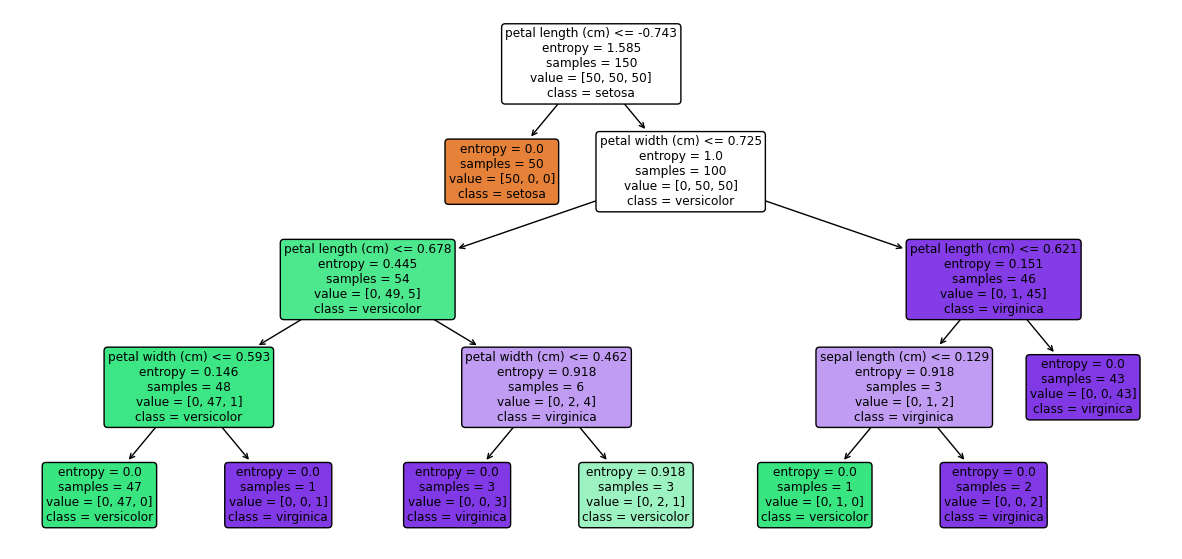

In [149]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15,7))
dot_data = plot_tree(tree_clf,
                            feature_names=iris_dataset['feature_names'], 
                            class_names=iris_dataset['target_names'], 
                            filled=True, rounded=True)
# Draw graph

In [150]:
def tune_depth(X_train= X_train, y_train= y_train, depth=0):
    tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)     ## take your time playing with all these hyperparams
    tree_clf.fit(X_train, y_train)   ## fit
    return tree_clf

In [151]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-3, 3, -3, 3], iris=True, legend=False, plot_training=True):

    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    if X.shape[1] == 2 :
        y_pred = clf.predict(X_new).reshape(x1.shape)
    else:
        y_pred = clf.predict(np.c_[X_new, X_new]).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507e50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        if X.shape[1] == 2 :
            plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
            plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
            plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        else:
            plt.plot(X[:, 2][y==0], X[:, 3][y==0], "yo", label="Iris setosa")
            plt.plot(X[:, 2][y==1], X[:, 3][y==1], "bs", label="Iris versicolor")
            plt.plot(X[:, 2][y==2], X[:, 3][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

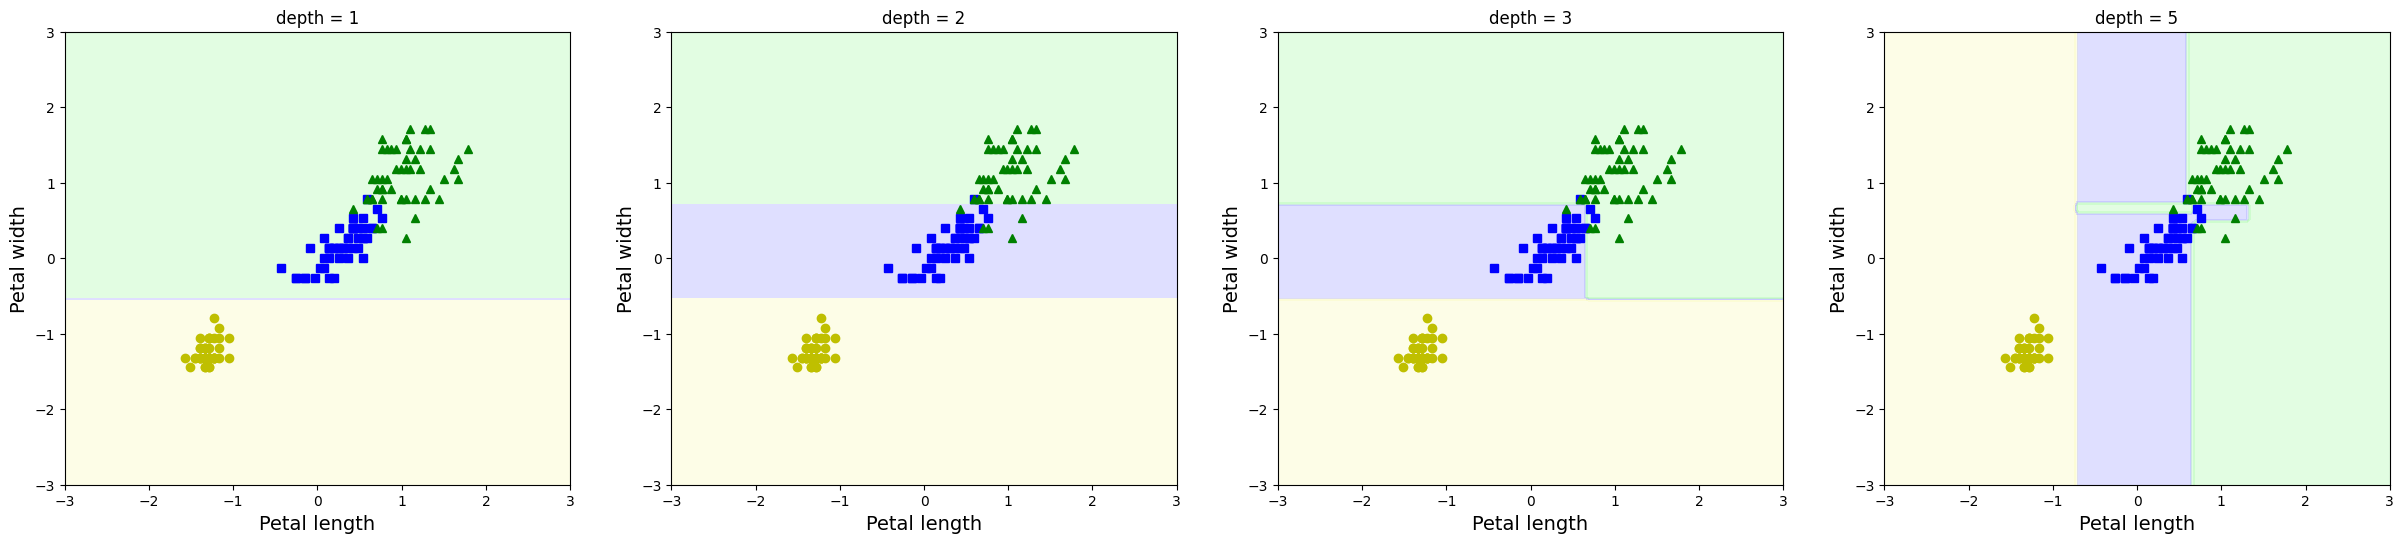

In [152]:
plt.figure(figsize=(30,20))
depth_for_tuning = [1,2,3,5]
for i in range(4):
    plt.subplot(3,4, i + 1)
    tree_clf = tune_depth(depth=depth_for_tuning[i])
    plot_decision_boundary(tree_clf, X_train , y_train, legend=False)
    plt.title(f'depth = {depth_for_tuning[i]}')
plt.show()

### Regularization using min_samples_leaf

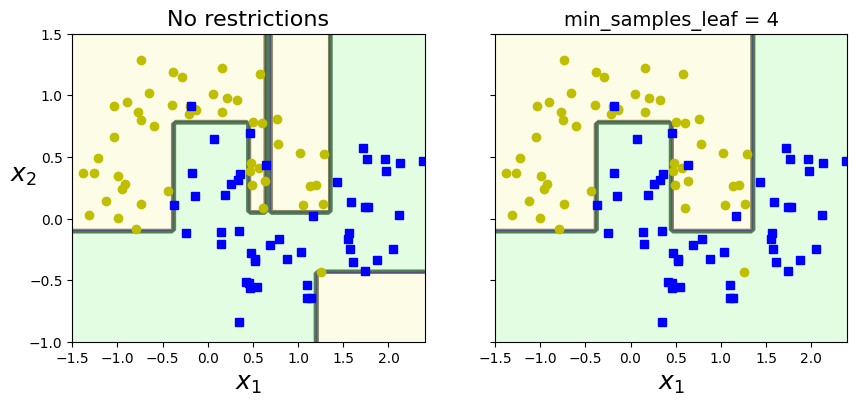

In [153]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

## `Regression`

In [154]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [155]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

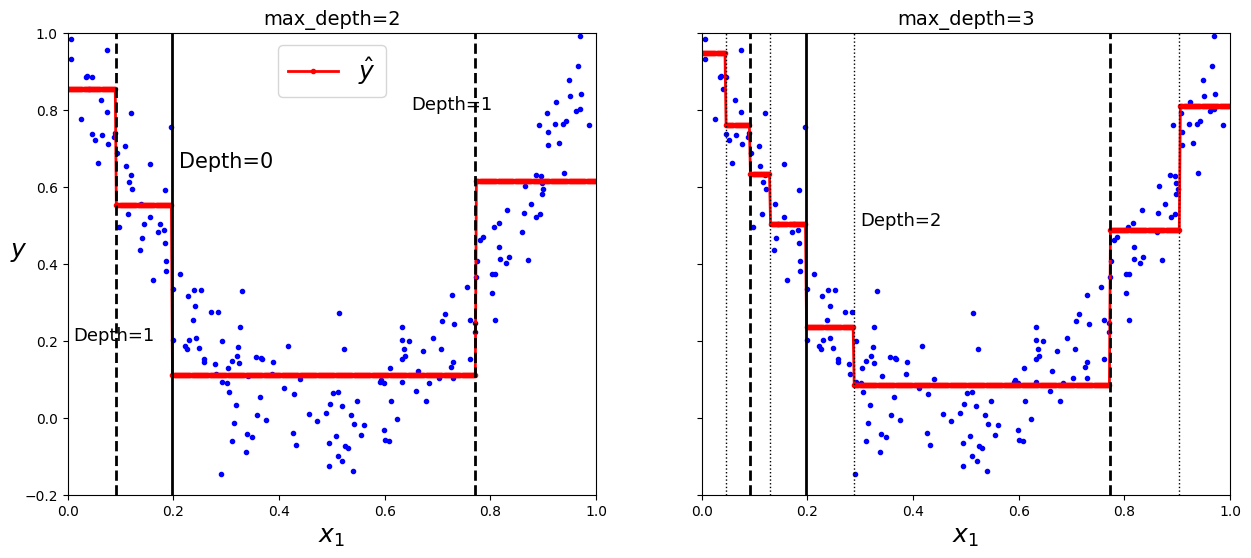

In [156]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)

plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

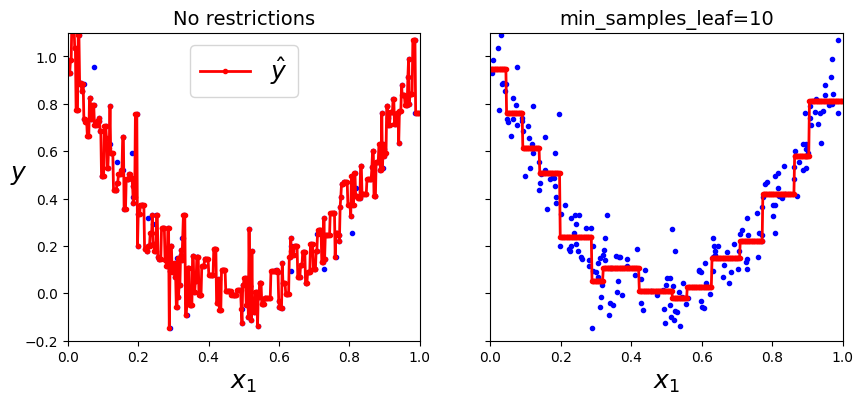

In [157]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)
plt.show()

In [158]:
## Loading the Dataset for Regression
diabet_dataset = datasets.load_diabetes()

## To DataFrame
df_diabet = pd.DataFrame(np.c_[diabet_dataset['data'], diabet_dataset['target'].reshape(-1, 1)], 
                         columns=diabet_dataset['feature_names']+['target'])

df_diabet.head()  

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [159]:
## Slice to Features and Traget
X_diabet = df_diabet.drop(columns=['target'], axis=1) 
y_diabet = df_diabet['target']


## Pipeline
diabet_pipeline = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', StandardScaler())
                                ]
                          )

## Fit
X_train_2 = diabet_pipeline.fit_transform(X_diabet)
y_train_2 = y_diabet.copy()

### `Building ML Model`
* > `Regression problem`

In [160]:
## DT, take your time playing with hyperparams, all is the same except the criterion
tree_reg = DecisionTreeRegressor(max_depth=2, criterion='squared_error')
tree_reg.fit(X_train_2, y_train_2)

DecisionTreeRegressor(max_depth=2)

In [161]:
## Predict using croos validation
y_scores_tree = cross_val_score(estimator=tree_reg, X=X_train_2, y=y_train_2, cv=5, n_jobs=-1, scoring='r2')
print(f'R2 Score using Trees -- {y_scores_tree.mean():.4f}')

print('---'*30)

## Prediction
y_pred_tree = cross_val_predict(estimator=tree_reg, X=X_train_2, y=y_train_2, cv=5, n_jobs=-1, method='predict')

R2 Score using Trees -- 0.3268
------------------------------------------------------------------------------------------


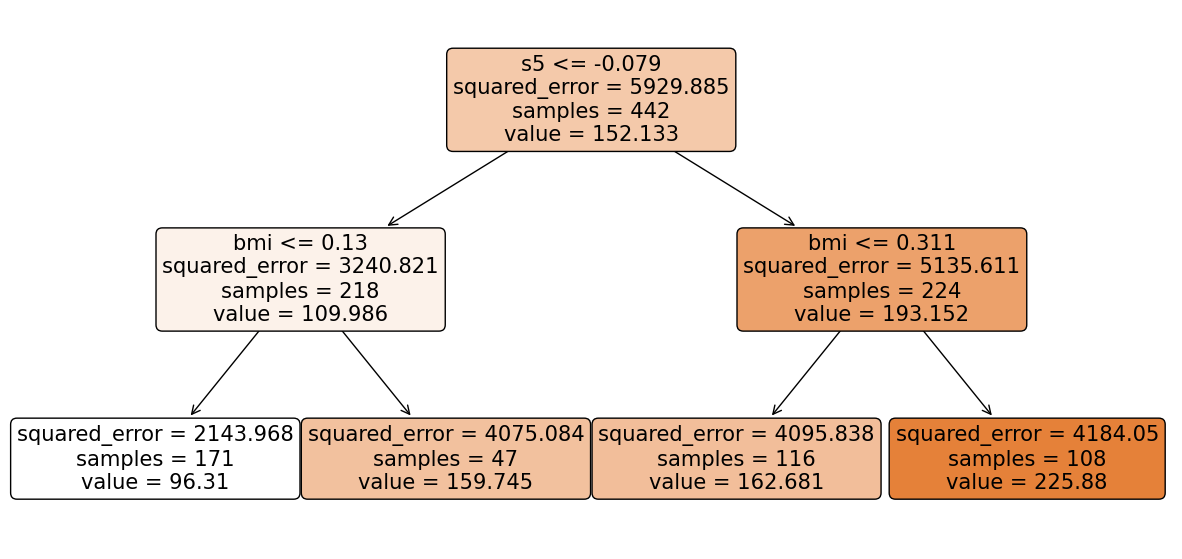

In [162]:
## Pass the model and the out_file, feature_names, class_names (as a list -- what you want (string or int))
## and options (rounded and filled) ---- and also what else you want
fig = plt.figure(figsize=(15,7))
dot_data = plot_tree(tree_reg,
                            feature_names=diabet_dataset['feature_names'], 
                            filled=True, rounded=True)
## The Graph